# SMU 7331 Data Mining Project 3
##### Authors: Shon Mohsin, Heber Nielsen, Jose Torres, Lokesh Maganti

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix, parallel_coordinates

from sklearn.metrics import pairwise
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import kneighbors_graph
from sklearn.mixture import GaussianMixture

import urllib
import re

## Business Understanding: 
#### Requirements: Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

In [2]:
# Data Import from Github
url = 'https://raw.githubusercontent.com/hebernielsen/DS7331_Project3/master/allUsers.lcl.csv' 
df=pd.read_csv(url)
df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,?,?,?,?,?,?,?,?,?,?
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,?,?,?,?,?,?,?,?,?,?
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,?,?,?,?,?,?,?,?,?,?
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,?,?,?,?,?,?,?,?,?,?


Our selected dataset captures hand gestures using Vicon Motion Capture System using a glove with markers, described in detail in the Data Understanding section. The dataset is comprised of 12 users making 5 pre-defined hand gestures below:

1. Fist
2. Stop
3. Point with one finger
4. Point with two fingers
5. Grab

The business problem is to perform cluster analysis on the 5 gestures, regardless of user, to see if discernable patterns can be used to identify the 5 gestures from a combined set where the 12 users are de-identified. 

Our assumption is that the gestures should be similar regardless of the individual user making the gesture. 

## Data Understanding 1:
#### Requirements: Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

### Data Overview

Our selected dataset captures hand gestures using Vicon Motion Capture System. Ten Vicon MX T40 (4 megapixel) motion capture cameras available in the Micro-Aerial Vehicle and Sensor Networks (MAVSeN) Laboratory at Louisiana Tech University act as the source of data. The MAVSeN lab conducts research and development in small-scale vehicle design, cooperative intelligent sensing, and control algorithms for unmanned air and ground vehicles (see Figure 1). As the figure partially shows, the cameras are arranged roughly on the boundary of a rectangular area. The cameras are capable of recording at multiple framerates, with 50 Hz and 100 Hz being the options used in the majority of situations including data capture and interactive tests.

	1. The Dataset is the collection,features and organization of motion capture datasets for hand posture and gesture recognition.

	2. The purpose of this dataset is to provide the range of motion for each part of the hand/glove to which a marker is attached.

	3. Glove constructed to serve as the source of data for all algorithms analysis and development.

	4. A glove with fifteen markers attached is used as the source of data for posture and gesture recognition, both for the generation of datasets and for the practical evaluation of developed algorithms.

	5. The glove used to capture data along with a sample from each class of posture projected onto the local XY plane. The classes are fist (1), stop (2),point with one finger (3), point with two fingers (4), and grab (5).

	6. The data described here is already partially preprocessed in the following manner. The data was transformed and pruned in the same manner as the La-beled Marker Dataset. Any record that could not be transformed or contained fewer than three markers was removed.

	7. This dataset may be used for a variety of tasks, the most obvious of which is posture recognition via classication. One may also attempt user identication.Alternatively, one may perform clustering (constrained or unconstrained) to discover marker distributions either as an attempt to predict marker identities or obtain statistical descriptions/visualizations of the postures.

	8. Since the pattern is not always visible and has noisy or even incorrect ob-servations, alter should be used to smooth the measurements of the labeled markers.

	9. The 11 markers not part of the rigid pattern were unlabeled; their positions were not explicitly tracked. Consequently, there is no a priori correspondence between the markers of two given records.


### Attribute Information:

Data is provided as a CSV file. A header provides the name of each attribute. An initial dummy record composed entirely of 0s should be ignored. A question mark '?' is used to indicate a missing value. A record corresponds to a single instant or frame as recorded by the camera system.

'Class' - Integer. The class ID of the given record. Ranges from 1 to 5 with 1=Fist(with thumb out), 2=Stop(hand flat), 3=Point1(point with pointer finger), 4=Point2(point with pointer and middle fingers), 5=Grab(fingers curled as if to grab). 'User' - Integer. The ID of the user that contributed the record. No meaning other than as an identifier.

Xi - Real. The x-coordinate of the i-th unlabeled marker position. 'i' ranges from 0 to 11.

'Yi' - Real. The y-coordinate of the i-th unlabeled marker position. 'i' ranges from 0 to 11.

'Zi' - Real. The z-coordinate of the i-th unlabeled marker position. 'i' ranges from 0 to 11.
Each record is a set. The i-th marker of a given record does not necessarily
correspond to the i-th marker of a dierent record. One may randomly permute
7
the visible (i.e. not missing) markers of a given record without changing the set
that the record represents. For the sake of convenience, all visible markers of
a given record are given a lower index than any missing marker. A class is not
guaranteed to have even a single record with all markers visible.

### Missing Data and Normalization:

The following preprocessing steps were made to this data:

1) Remove Class 0, which is not a valid Class.
2) Replace '?' values with np.NaN

In [3]:
dropped_indices = df.query('Class==0').index
df = (df
      .drop(labels=dropped_indices, axis=0, errors='ignore')
      .replace(to_replace='?', value=np.nan))

#set data types and melt to a single coordinate column
df = (pd.concat([df.iloc[:,:2].astype(str), 
                df.iloc[:,2:].astype(np.float64)], axis=1)
      .melt(id_vars=['User', 'Class'])
      .dropna())

In [4]:
#replace column names with X or Y or Z depending on the axis, and relabel the classes

df['variable'] = (df['variable'].str
                  .replace('X.*', 'X', regex=True)
                  .replace('Y.*', 'Y', regex=True)
                  .replace('Z.*', 'Z', regex=True))
df['Class'] = df['Class'].map({'1': 'fist', '2': 'stop', 
                               '3': 'pointer', '4': 'pointer_middle', '5': 'grab'})

In [5]:
#Cleaned dataframe

df.head()

,User,Class,variable,value
0,0,fist,X,54.263880
1,0,fist,X,56.527558
2,0,fist,X,55.849928
3,0,fist,X,55.329647
4,0,fist,X,55.142401


In [6]:
#Pivot coordinates to have columns User, Class, X, Y, Z

df_adjacent_coords = pd.DataFrame({'User': df.query('variable==\'X\'').reset_index()['User'], 
                                   'Class': df.query('variable==\'X\'').reset_index()['Class'], 
                                   'X': df.query('variable==\'X\'').reset_index()['value'], 
                                   'Y': df.query('variable==\'Y\'').reset_index()['value'],
                                   'Z': df.query('variable==\'Z\'').reset_index()['value']})
df_adjacent_coords.head()

,User,Class,X,Y,Z
0,0,fist,54.263880,71.466776,-64.807709
1,0,fist,56.527558,72.266609,-61.935252
2,0,fist,55.849928,72.469064,-62.562788
3,0,fist,55.329647,71.707275,-63.688956
4,0,fist,55.142401,71.435607,-64.177303


In [7]:
# We group by `User` to see the participation percentage levels of each user 
df.groupby(['User']).agg(lambda grp: grp.size / df.shape[0] * 100)[['Class']]

,Class
User,
0,10.986705
1,5.787110
10,12.374396
11,10.492454
12,5.956161
13,10.380570
14,9.999510
2,5.555664
4,0.373710


### Data Visualization:

The helper functions below are useful in assisting with data visualization.

In [8]:
def make_canvas(title):
    fig = plt.figure(figsize=(24,10))
    plt.style.use('ggplot')

    fig.subplots_adjust(hspace=0.0, wspace=0.2)

    xy = fig.add_subplot(1,3,1)
    xz = fig.add_subplot(1,3,2)
    yz = fig.add_subplot(1,3,3)

    fig.suptitle(title, fontsize=30)

    xy.set_title('X-Y Perspective')
    xy.set_xlabel('X', fontsize=20)
    xy.set_ylabel('Y', fontsize=20, rotation=0)

    xz.set_title('X-Z Perspective')
    xz.set_xlabel('X', fontsize=20)
    xz.set_ylabel('Z', fontsize=20, rotation=0)

    yz.set_title('Y-Z Perspective')
    yz.set_xlabel('Y', fontsize=20)
    yz.set_ylabel('Z', fontsize=20, rotation=0)
    
    return xy, xz, yz

def data_query(data, gesture, user):
    result = (data
             .query('Class in \'{}\' and User in \'{}\''.format(gesture, user))
             .loc[:,['X','Y','Z']]
             .values)
    return result


Our first visualization is of the Fist Gesture in 3D and separate 2D planes.  Here is the reference image of representative clusters we would expect to see for each user (XY plane) <img src="files/Fist.png"> <img src="files/Grab.png"> <img src="files/PointOneFinger.png"> <img src="files/PointTwoFingers.png"> <img src="files/Stop.png">.

As reference, we use user 1 and 2, as different users have different consistency on the clustering that is captured.

In [9]:
import ipyvolume as ipv
ipv.clear()
X = data_query(df_adjacent_coords, 'fist', '0')
scatter_fist = ipv.scatter(X[:,0],X[:,1],X[:,2],color='blue',size=.25)
ipv.show()

In [10]:
import ipyvolume as ipv
ipv.clear()
X = data_query(df_adjacent_coords, 'fist', '1')
scatter_fist = ipv.scatter(X[:,0],X[:,1],X[:,2],color='blue',size=.25)
ipv.show()

In the abov 3D plots, we visualize the data for the fist motion for users 0 and 1 to see the variability present between users performing the same gesture. To be consise, we do not visualize the rest of the gestures. 

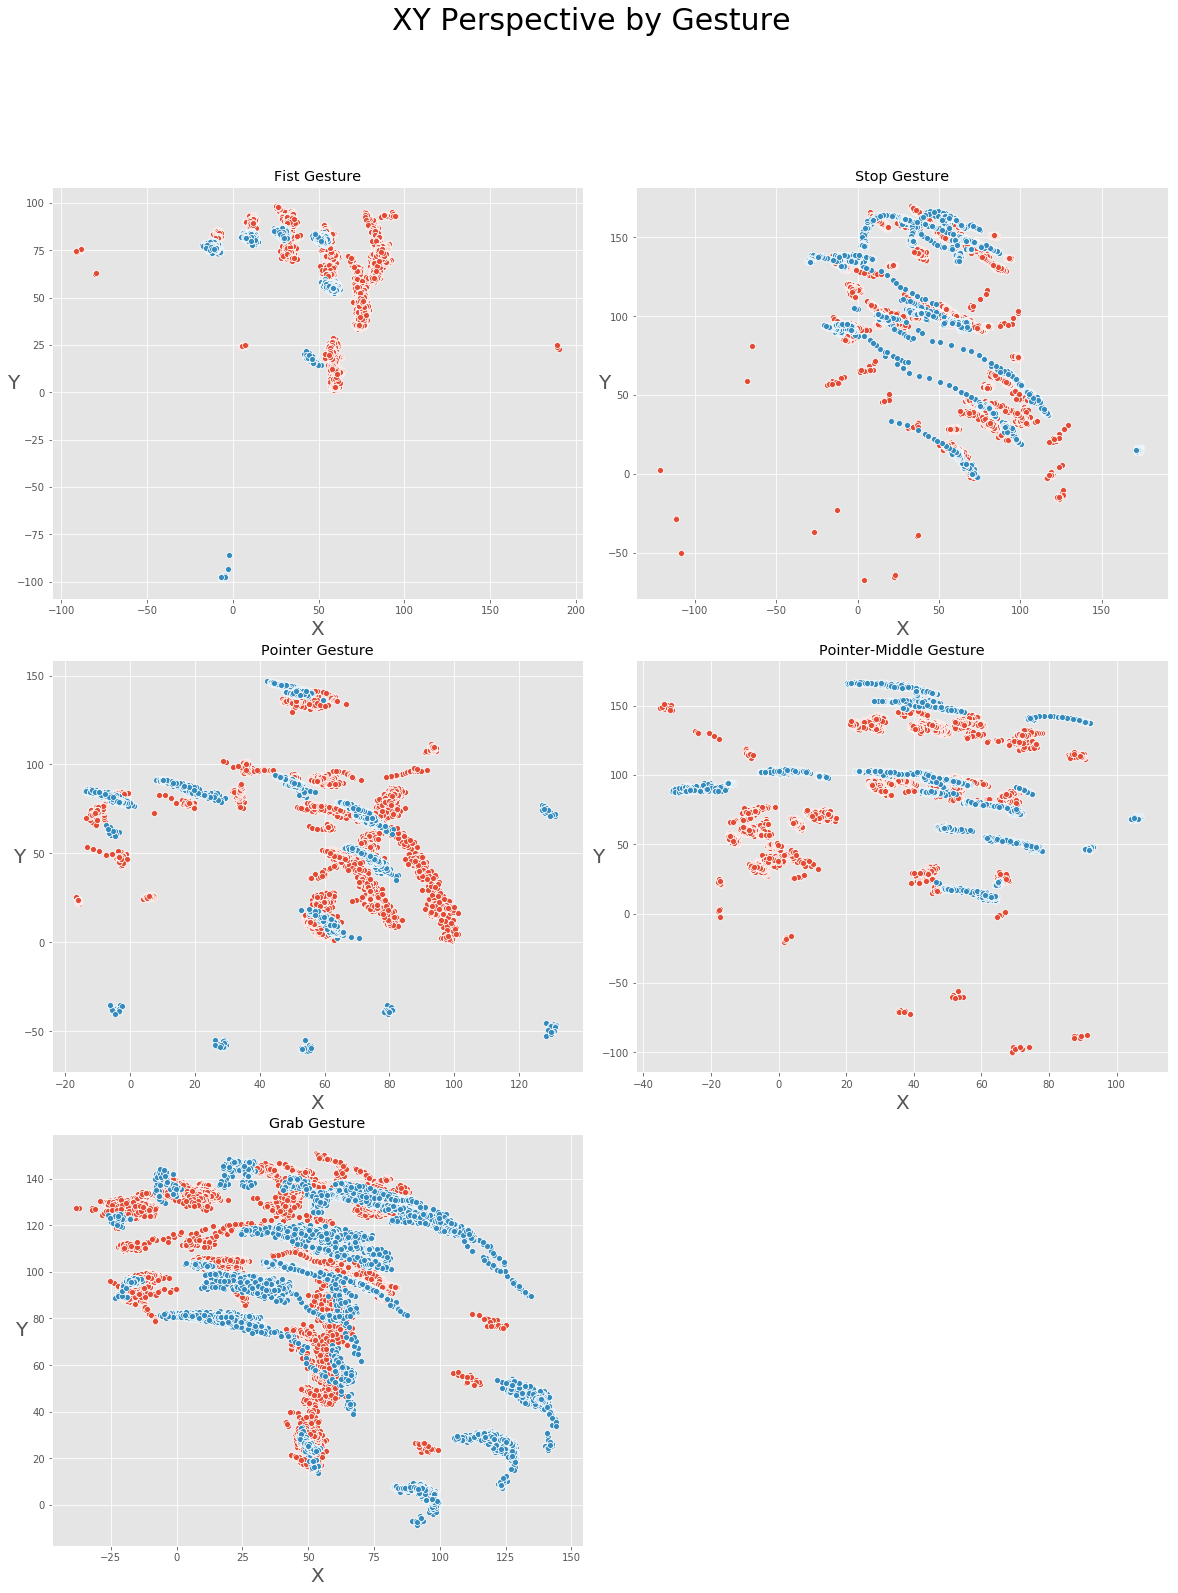

In [11]:
fig = plt.figure(figsize=(20,25))
plt.style.use('ggplot')

fig.subplots_adjust(hspace=0.15, wspace=0.1)

fist = fig.add_subplot(3,2,1)
stop = fig.add_subplot(3,2,2)
pointer = fig.add_subplot(3,2,3)
pointer_middle = fig.add_subplot(3,2,4)
grab = fig.add_subplot(3,2,5)


fig.suptitle('XY Perspective by Gesture', fontsize=30)

fist.set_title('Fist Gesture')
fist.set_xlabel('X', fontsize=20)
fist.set_ylabel('Y', fontsize=20, rotation=0)

stop.set_title('Stop Gesture')
stop.set_xlabel('X', fontsize=20)
stop.set_ylabel('Y', fontsize=20, rotation=0)

pointer.set_title('Pointer Gesture')
pointer.set_xlabel('X', fontsize=20)
pointer.set_ylabel('Y', fontsize=20, rotation=0)

pointer_middle.set_title('Pointer-Middle Gesture')
pointer_middle.set_xlabel('X', fontsize=20)
pointer_middle.set_ylabel('Y', fontsize=20, rotation=0)

grab.set_title('Grab Gesture')
grab.set_xlabel('X', fontsize=20)
grab.set_ylabel('Y', fontsize=20, rotation=0)


sns.scatterplot(x=data_query(df_adjacent_coords, 'fist', '0')[:,0], 
                y=data_query(df_adjacent_coords, 'fist', '0')[:,1], ax=fist)

sns.scatterplot(x=data_query(df_adjacent_coords, 'fist', '1')[:,0], 
                y=data_query(df_adjacent_coords, 'fist', '1')[:,1], ax=fist)

sns.scatterplot(x=data_query(df_adjacent_coords, 'stop', '0')[:,0], 
                y=data_query(df_adjacent_coords, 'stop', '0')[:,1], ax=stop)

sns.scatterplot(x=data_query(df_adjacent_coords, 'stop', '1')[:,0], 
                y=data_query(df_adjacent_coords, 'stop', '1')[:,1], ax=stop)

sns.scatterplot(x=data_query(df_adjacent_coords, 'pointer', '0')[:,0], 
                y=data_query(df_adjacent_coords, 'pointer', '0')[:,1], ax=pointer)

sns.scatterplot(x=data_query(df_adjacent_coords, 'pointer', '1')[:,0], 
                y=data_query(df_adjacent_coords, 'pointer', '1')[:,1], ax=pointer)

sns.scatterplot(x=data_query(df_adjacent_coords, 'pointer_middle', '0')[:,0], 
                y=data_query(df_adjacent_coords, 'pointer_middle', '0')[:,1], ax=pointer_middle)

sns.scatterplot(x=data_query(df_adjacent_coords, 'pointer_middle', '1')[:,0], 
                y=data_query(df_adjacent_coords, 'pointer_middle', '1')[:,1], ax=pointer_middle)

sns.scatterplot(x=data_query(df_adjacent_coords, 'grab', '0')[:,0], 
                y=data_query(df_adjacent_coords, 'grab', '0')[:,1], ax=grab)

sns.scatterplot(x=data_query(df_adjacent_coords, 'grab', '1')[:,0], 
                y=data_query(df_adjacent_coords, 'grab', '1')[:,1], ax=grab)

plt.show()

We see from plotting the point on the X-Y plane that the gestures from 2 users map fairly consistently to the predefined image, when accounting for within-user variability. 

## Data Understanding 2:
#### Requirements: Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

We will use silhouette analysis to determine the degree of separation between clusters. Our goal is to have the coefficients be as close to 1 as possible to have good clusters. 

Initial Test
1. Select all fist gesture points for all users
2. 

## Modeling and Evaluation 1:
#### Requirements: Train and adjust parameters

### Number of clusters with silhouette analysis on KMeans clustering

We perform silhouette analysis with K-means clustering using n=(2,3,4,5,6) clusters to generage average silhouette scores. To be conscise, we only analyse the Fist gesture using K-means. Our evaluation looks at 5 values of n and the interpretation of the cluster outcomes of those values. 

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.42789734017111325
For n_clusters = 3 The average silhouette_score is : 0.3776609464618513
For n_clusters = 4 The average silhouette_score is : 0.41151744927742795
For n_clusters = 5 The average silhouette_score is : 0.38376351881037485
For n_clusters = 6 The average silhouette_score is : 0.3962371765911298


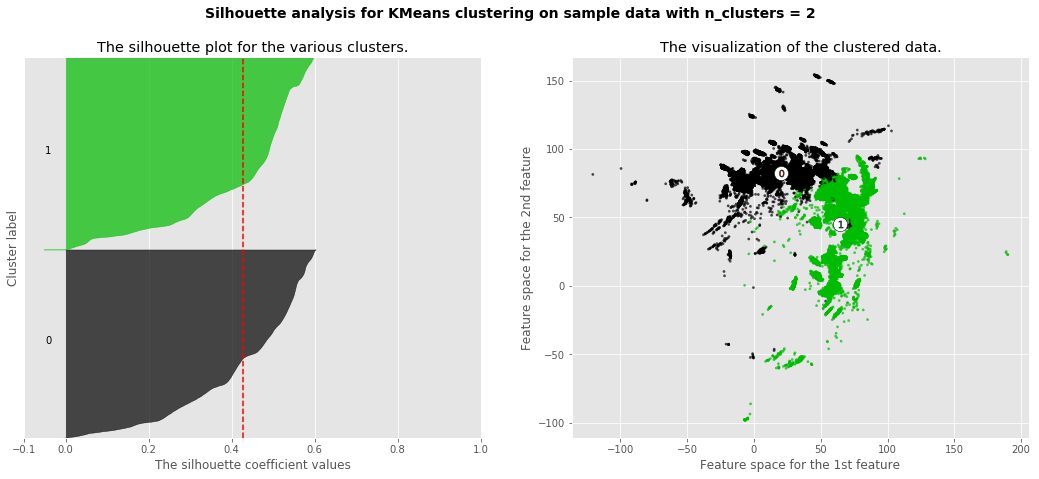

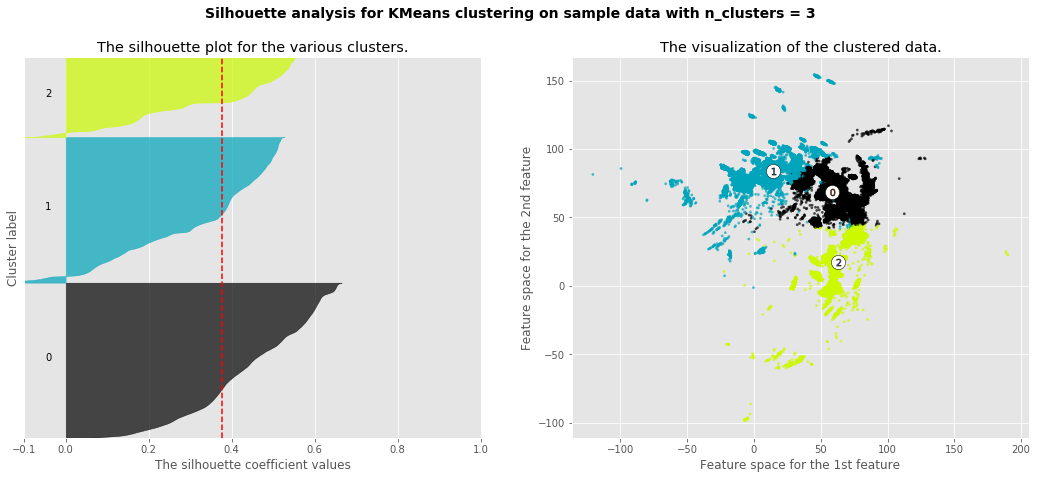

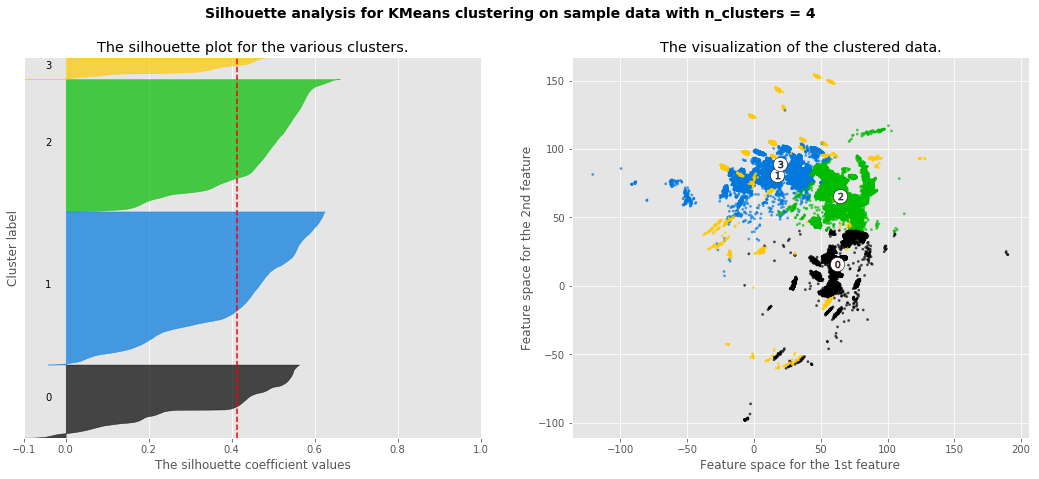

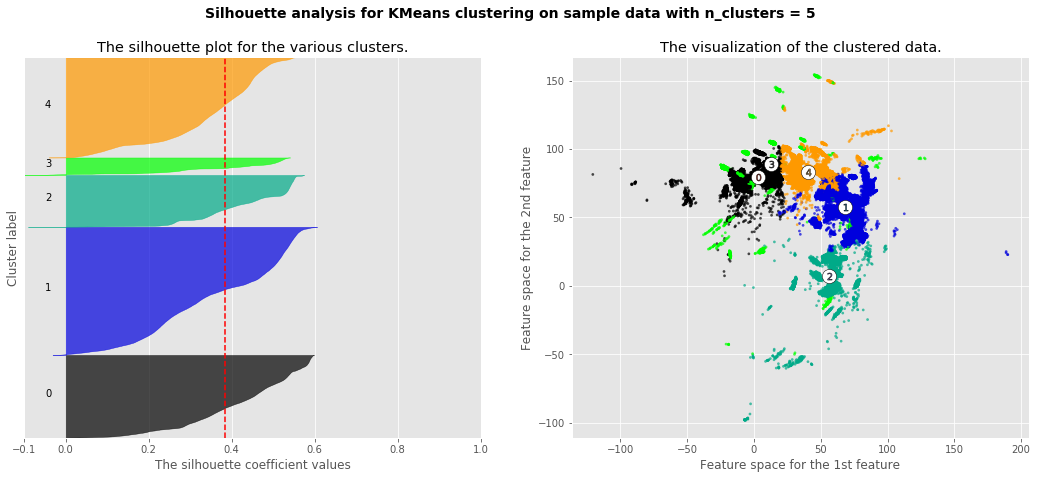

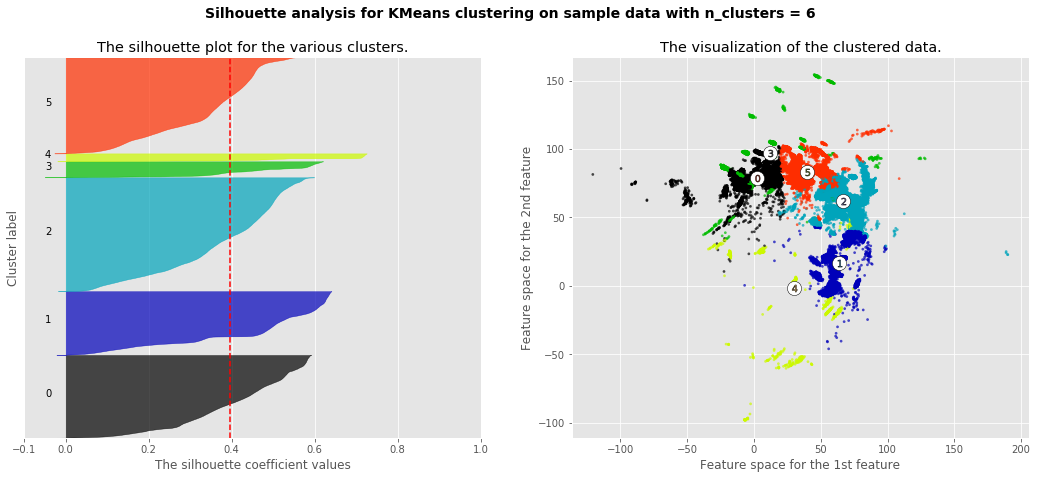

In [13]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

y = df_adjacent_coords['Class']
X = (df_adjacent_coords
     .query('Class==\'fist\'')
     .loc[:,['X','Y','Z']]
     .values)

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## Modeling and Evaluation 1:
#### Requirements: Evaluate and Compare

In [20]:
for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.42789734017111325
For n_clusters = 3 The average silhouette_score is : 0.3776609464618513
For n_clusters = 4 The average silhouette_score is : 0.41151744927742795
For n_clusters = 5 The average silhouette_score is : 0.38376351881037485
For n_clusters = 6 The average silhouette_score is : 0.3962371765911298


## Modeling and Evaluation 3:
#### Requirements: Visualize Results

KeyboardInterrupt: 

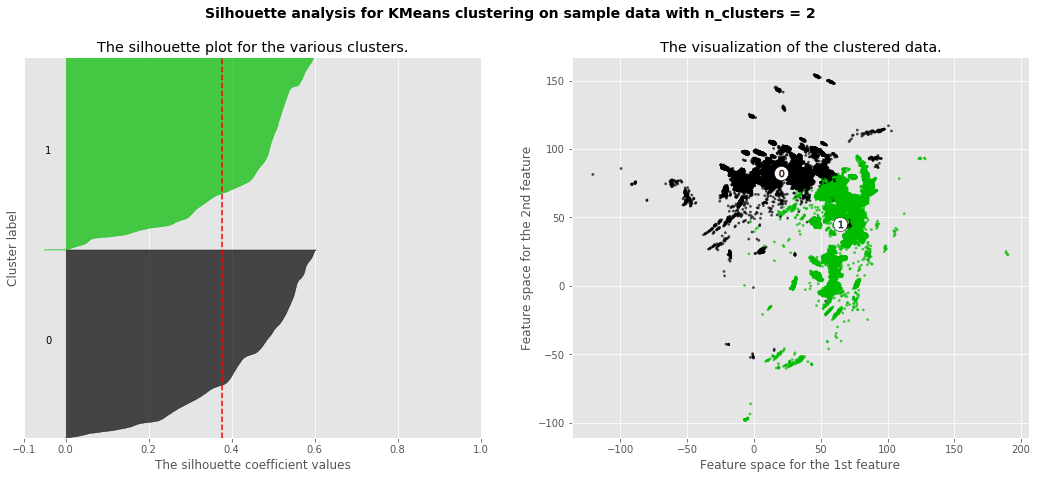

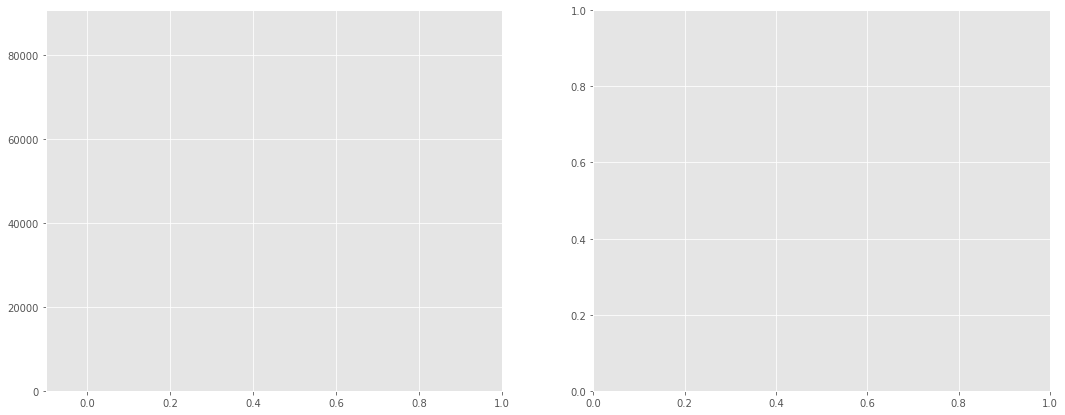

In [30]:
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## Modeling and Evaluation 4:
#### Requirements: Summarize the Remifications

## Deployment:
#### Requirements: Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?
##### How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
##### How would your deploy your model for interested parties?
##### What other data should be collected? 
#####  How often would the model need to be updated, etc.?

### Exceptional Work:
#### Requirements: You have free reign to provide additional analyses or combine analyses.

### (FROM HERE ONWARDS, THESE ARE SECTIONS WE MIGHT USE AS SUBSECTIONS WITHIN THE MAIN SECTIONS ABOVE.
##### -Heber)

## Evaluation:

## Data Preparation:

#### Data Meaning Type:

## Data Quality:

### Missing Values:

### Outliers:

## Data Visualization and Visual Analysis:

## Summary Statistics and Commentary:

### Main Observations: